In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
df_clusters = pd.read_csv('C:\\Users\\Brend\\Downloads\\clusters_top42.csv', index_col = 'name', encoding = "UTF-8")
df_pct_collab = pd.read_csv('C:\\Users\\Brend\\Downloads\\pct_collaborative_pubs_top42.csv', index_col = 'name', encoding = 'UTF-8')
df_pct_collab_new = pd.read_csv('C:\\Users\\Brend\\Downloads\\pct_collaborative_pubs_top42_v2.csv', index_col = 'name', encoding = 'UTF-8')
df_impact = pd.read_csv('C:\\Users\\Brend\\Downloads\\impact_top42.csv', index_col = 'name', encoding = 'UTF-8')
df_author_focus = pd.read_csv('C:\\Users\\Brend\\Downloads\\community_focus_top42.csv', index_col = 'name', encoding = 'UTF-8')
df_disrupt = pd.read_csv('C:\\Users\\Brend\\Downloads\\disrupt_profs_top42.csv', index_col = 'name', encoding = 'UTF-8')
df_unique_profs = pd.read_csv('C:\\Users\\Brend\\Downloads\\unique_profs_top42.csv', index_col = 'name', encoding = "UTF-8")
df_orgs = pd.read_csv('C:\\Users\\Brend\\Downloads\\orgs_top42.csv', index_col = 'name', encoding = "UTF-8")

In [2]:
df_all = df_pct_collab.join(df_clusters[['TotalConns', 'InterClusterRatio', 'IntraClusterRatio']], how = 'outer')
df_all = df_all.join(df_impact, how = 'outer')
df_all = df_all.join(df_author_focus, how = 'outer')
df_all = df_all.join(df_disrupt, how = 'outer')
df_all = df_all.join(df_unique_profs, how = 'outer')

In [15]:
df_trimmed = df_all[df_all['num_pubs'] >= 50]
df_trimmed = df_trimmed[df_trimmed['TotalConns'] >= 25]
df_trimmed = df_trimmed[df_trimmed['num_disrupt'] >= 10]
print("Remaining after trimming: %d authors" % df_trimmed.shape[0])

Remaining after trimming: 53745 authors


In [12]:
linear_metrics = ['pct_collab_linauth', 'pct_collab_linprof', 
                  'pct_collab_sqrtauth', 'pct_collab_sqrtprof', 
                  'pct_collab_unweighted', 'InterClusterRatio', 
                  'IntraClusterRatio']
log_metrics = ['IntraCommunityFocus', 'InterCommunityFocus']
all_metrics = linear_metrics + log_metrics
impact = ['avg_PR', 'max_PR', 'avg_AR', 'max_AR']
disrupt = ['avg_disrupt', 'max_disrupt', 'median_disrupt', 'min_disrupt']
unique_coauthor_profs = ['unique_coauthor_profs', 'unique_coauthor_profs_damped']


In [16]:
df_log = df_trimmed.copy()
for col in df_trimmed.columns:
    log_col = df_log[[col]]
    df_log[col + '_log'] = log_col.apply(np.log, axis=0)
df_log = df_log[[col for col in df_log.columns if 'log' in col]]

In [17]:
df_log_adjusted = df_trimmed.copy()
for col in df_trimmed.columns:
    log_col = df_log_adjusted[[col]]
    df_log_adjusted[col + '_log_adj'] = log_col.apply(lambda x: np.log(x+1), axis=0)
df_log_adjusted = df_log_adjusted[[col for col in df_log_adjusted.columns if 'log' in col]]

In [18]:
df_scaled = df_trimmed.copy()
for col in df_trimmed.columns:
    ss = StandardScaler()
    scaled_col = df_scaled[[col]]
    df_scaled[col + '_zscore'] = ss.fit_transform(scaled_col)
df_zscores = df_scaled[[col for col in df_scaled.columns if 'zscore' in col]]

In [19]:
processing = dict()
for c in linear_metrics:
    processing[c] = 'zscore'
for c in log_metrics:
    processing[c] = 'log_adj'
for c in impact:
    processing[c] = 'log'
for c in disrupt:
    processing[c] = 'log_adj'
for c in unique_coauthor_profs:
    processing[c] = 'log'
df_table = {'zscore': df_zscores, 'log': df_log, 'log_adj': df_log_adjusted}

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
sns.set(color_codes=True)
%matplotlib inline

In [20]:
def joint_plot(x_cols, y_cols):
    for x_col in x_cols:
        for y_col in y_cols:   
            X = df_table[processing[x_col]][[x_col + '_' + processing[x_col]]]
            y = df_table[processing[y_col]][[y_col + '_' + processing[y_col]]]
            df_X_notinf = X.replace([np.inf, -np.inf], np.nan)
            df_y_notinf = y.replace([np.inf, -np.inf], np.nan)
            df_X_notna = df_X_notinf.dropna(subset=[x_col + '_' + processing[x_col]])
            df_y_notna = df_y_notinf.dropna(subset=[y_col + '_' + processing[y_col]])
            df_reg = df_X_notna.join(df_y_notna, how = 'inner')
            X = df_reg[[x_col + '_' + processing[x_col]]]
            y = df_reg[[y_col + '_' + processing[y_col]]]
            data = pd.concat([X, y], axis=1)
            f, ax = plt.subplots(figsize=(8,8))
            g = sns.regplot(x_col + '_' + processing[x_col], y_col + '_' + processing[y_col], data, ax=ax, dropna = True, fit_reg=False, scatter_kws={"color":"darkred","alpha":0.3,"s":1})
            plt.show()

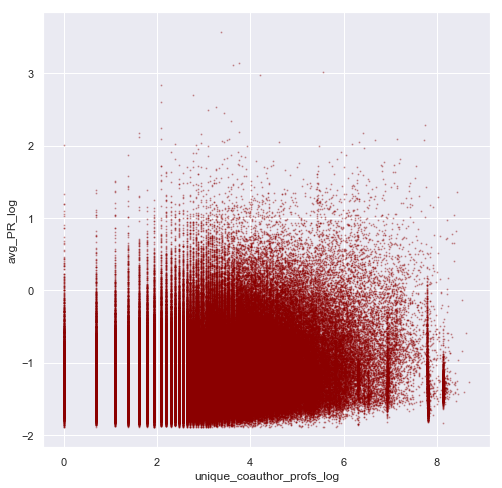

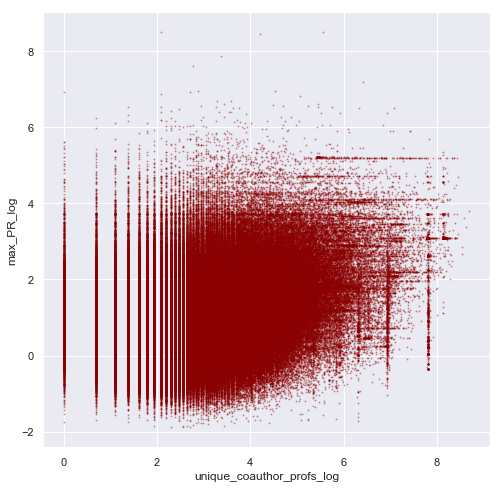

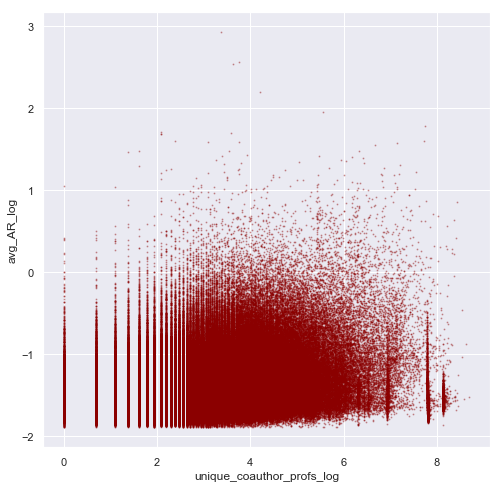

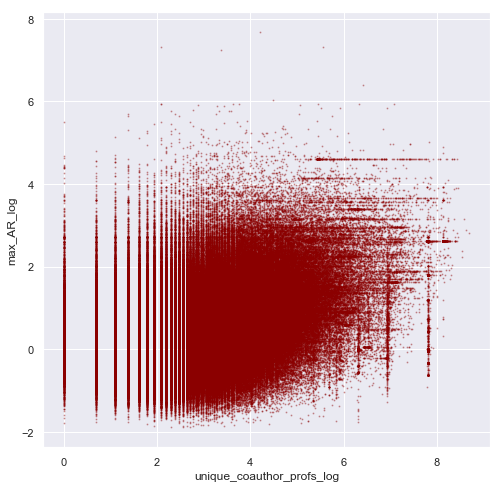

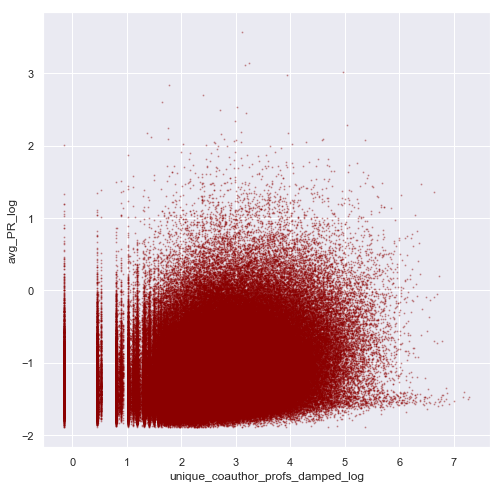

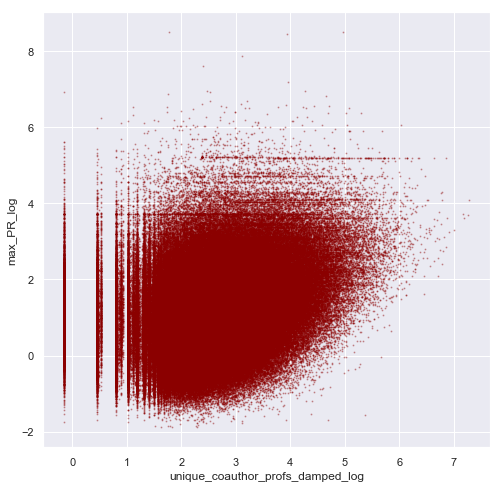

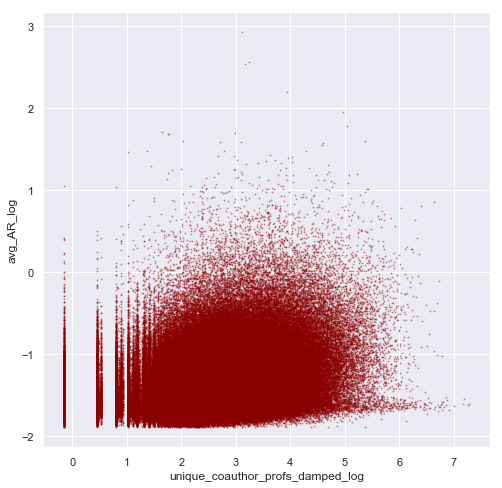

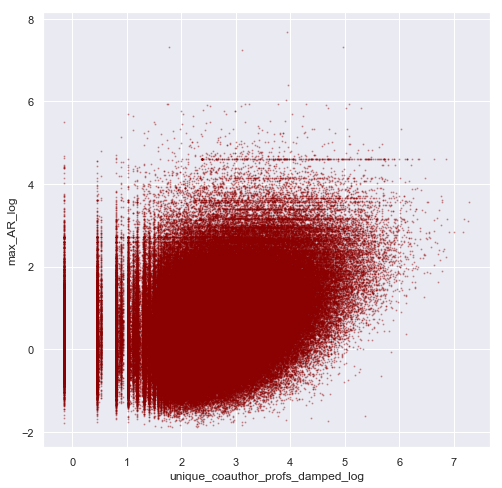

In [14]:
joint_plot(unique_coauthor_profs, impact)

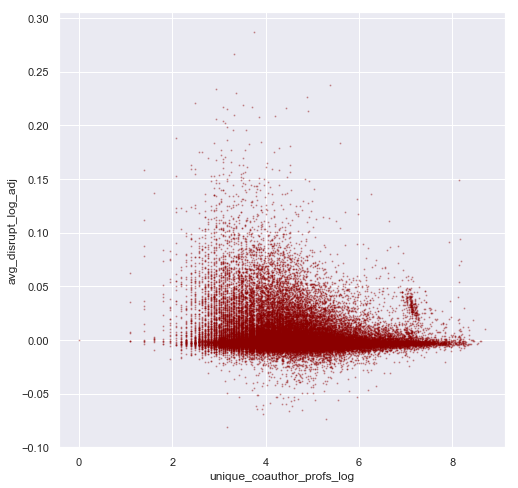

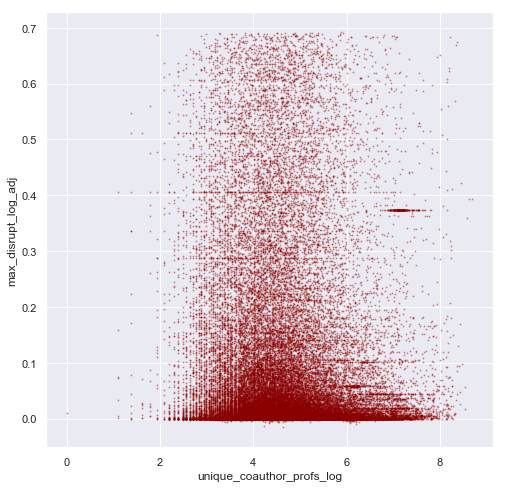

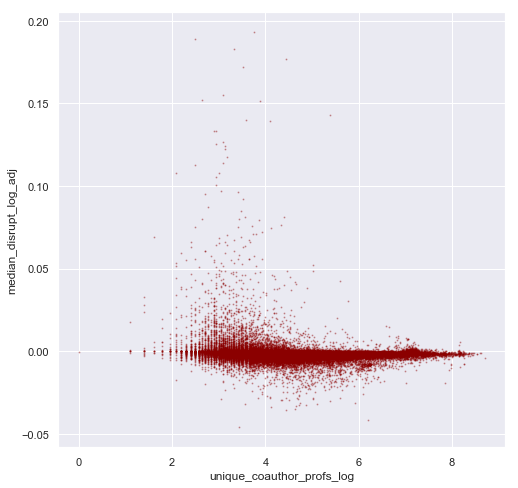

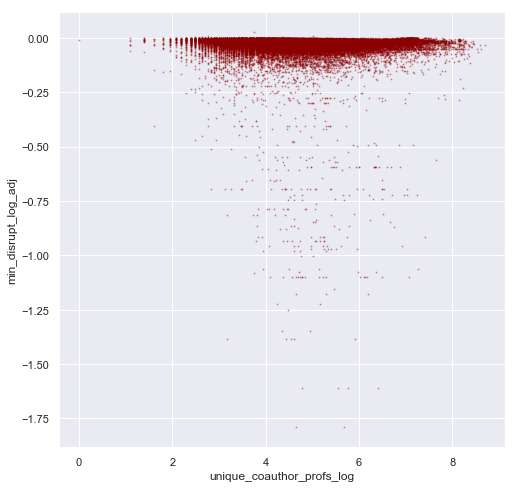

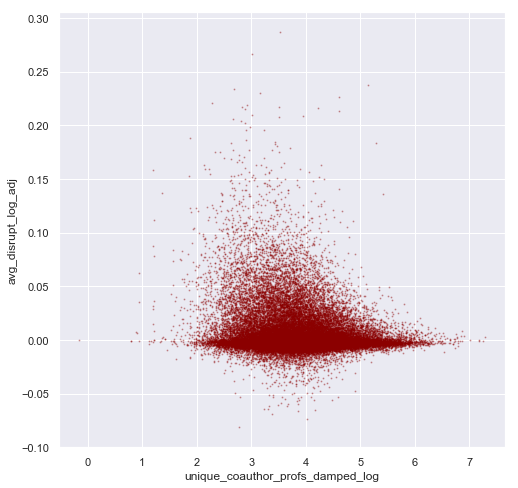

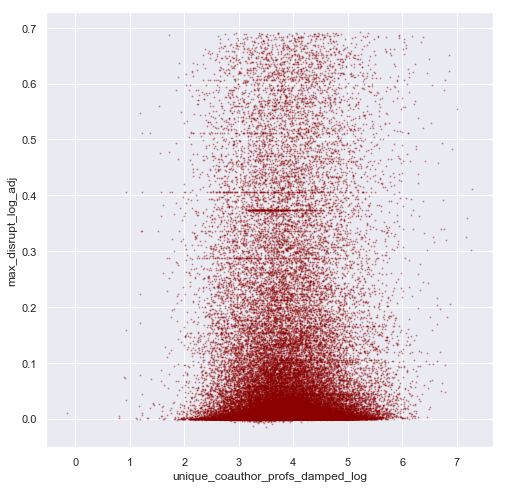

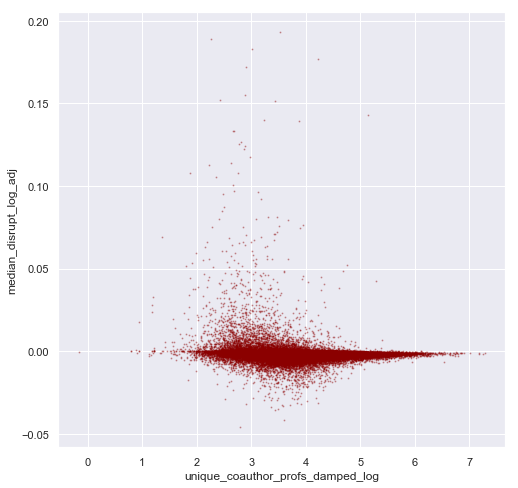

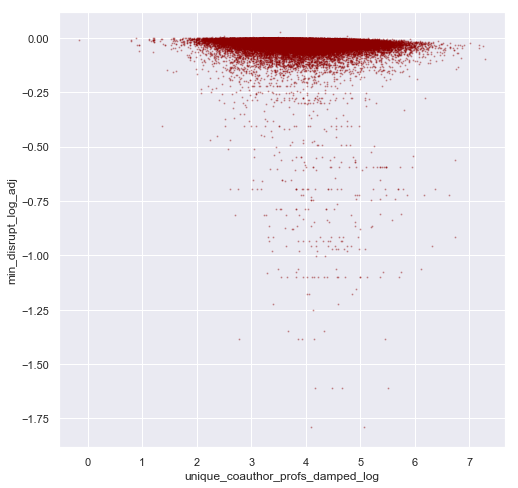

In [21]:
joint_plot(unique_coauthor_profs, disrupt)

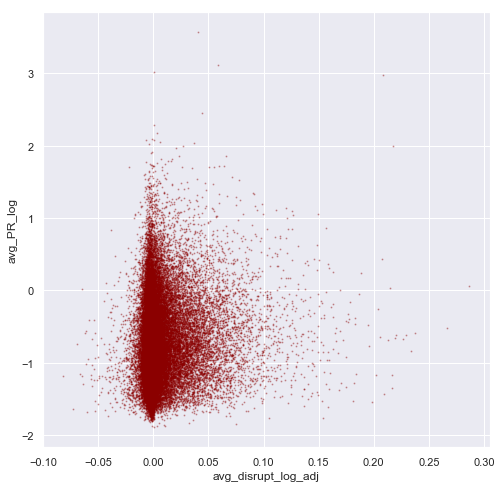

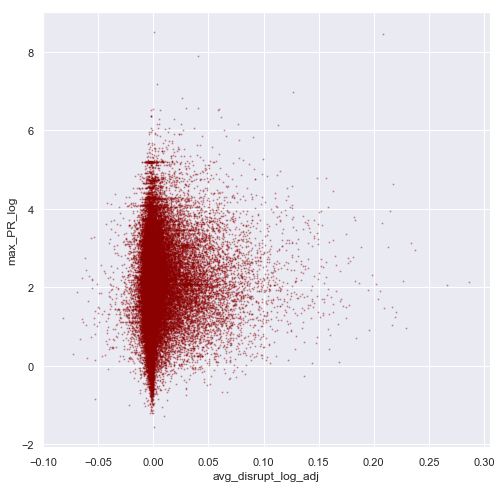

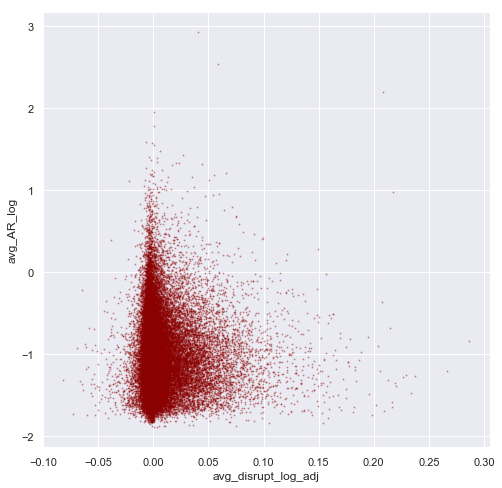

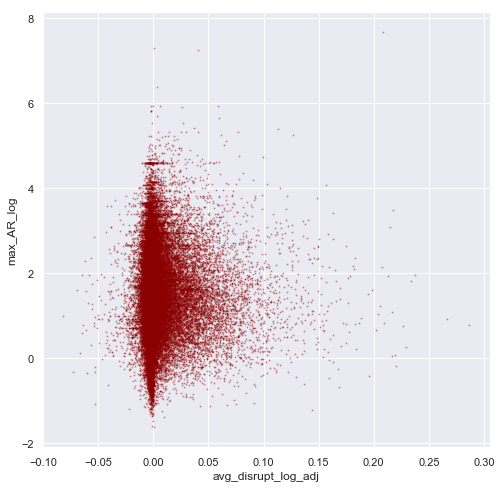

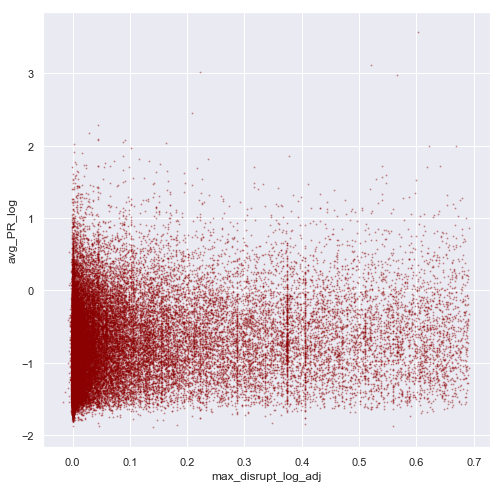

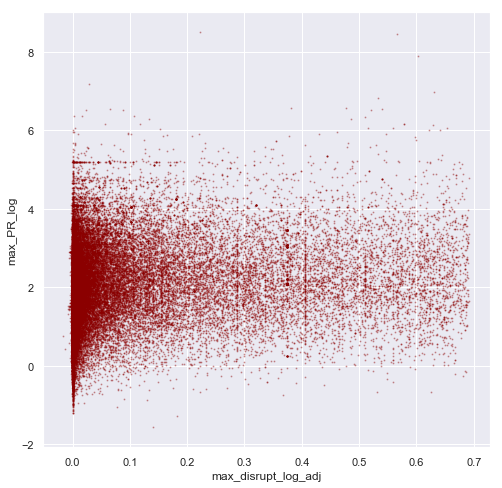

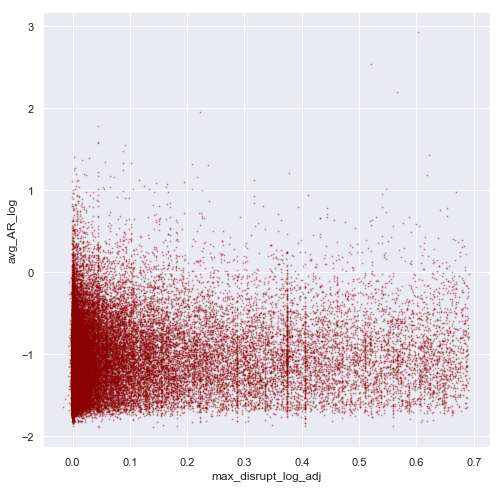

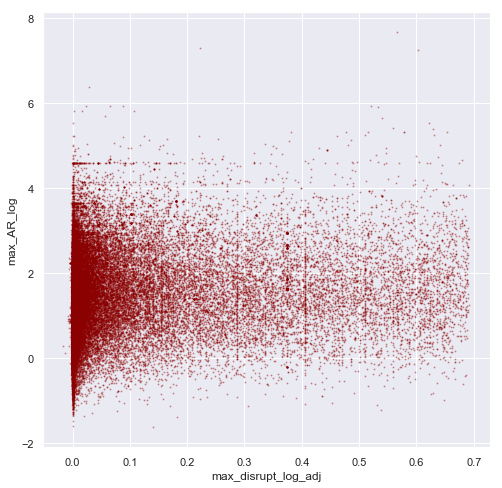

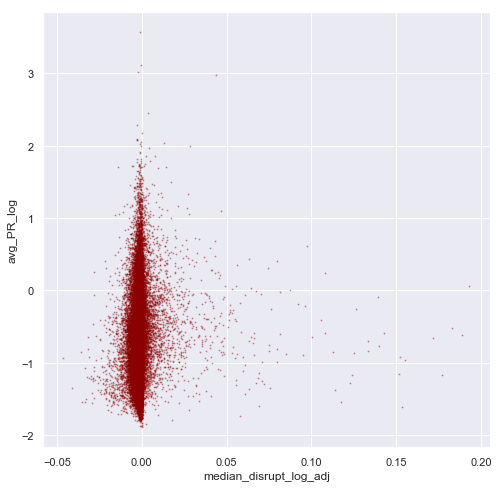

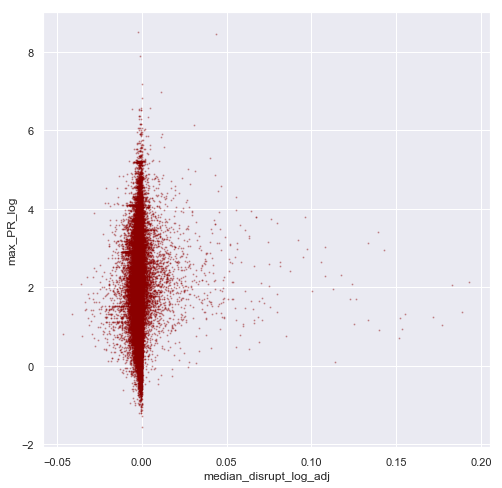

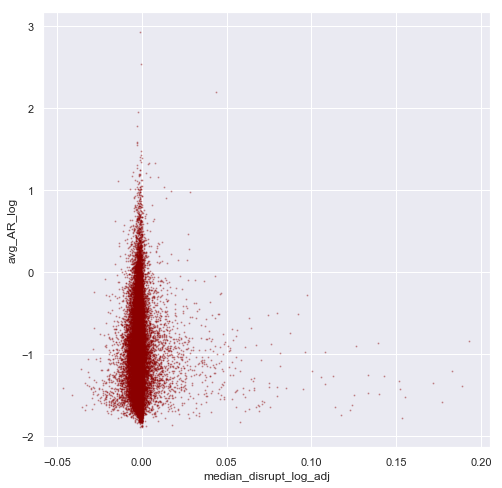

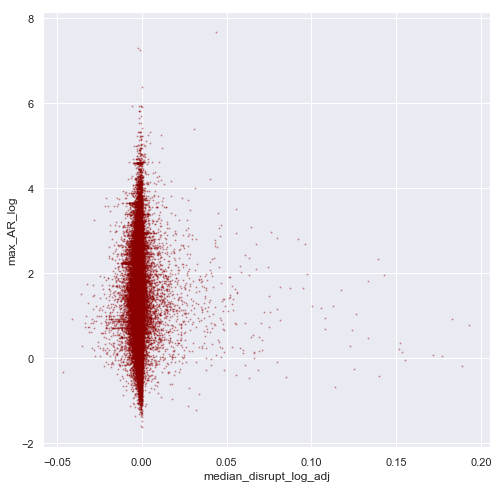

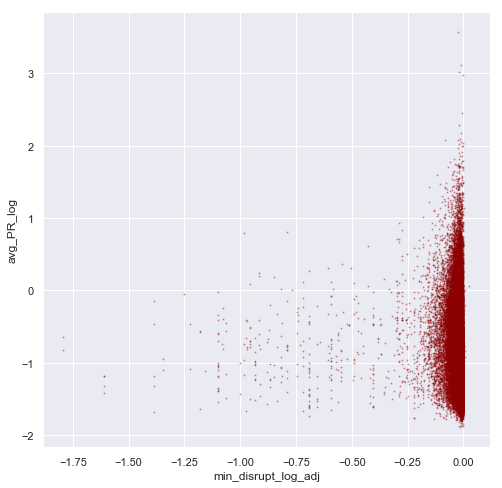

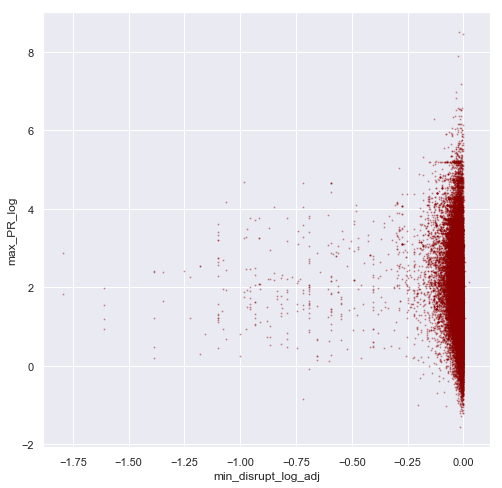

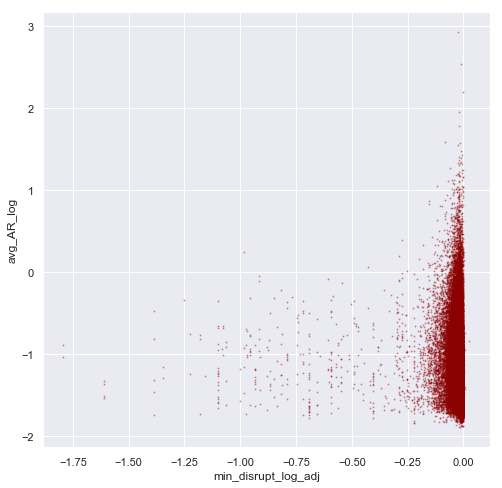

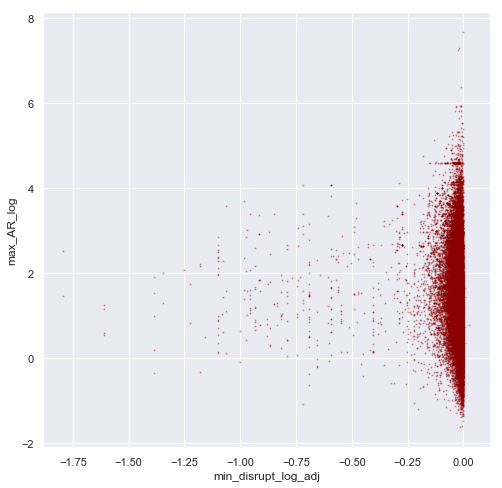

In [23]:
joint_plot(disrupt, impact)